# **Classification exercise for Machine Learning Course in UNIBO**

In [267]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


**Loading Data**

> Reading a dataset from a CSV file and creating a DataFrame, setting the first column as the index, and naming the columns with the given names.

**Exploring Data**

> Displaying the first five rows of the dataset.




In [233]:
names = ['Gender', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
df = pd.read_csv('2023-01-09.csv', sep=',', index_col=0, header=None, names=names)

In [ ]:
df.head()

**Encoding Categorical Data**

> Encode categorical features using LabelEncoder from scikit-learn.

**Filling Null Values**

> Replace missing values in all numerical features with their mean.

In [234]:
lencoder = LabelEncoder()
df['Gender'] = lencoder.fit_transform(df['Gender'])

In [235]:
df.fillna(df.mean(), inplace=True)

**Exploring Data**

> Displaying the size of the dataset and visualizing the data using various plots.

In [ ]:
df.describe()

In [ ]:
print("the shape of the data set is "+str(df.shape))

In [ ]:
sns.pairplot(df)

In [ ]:
df.hist()

In [ ]:
sns.boxplot(df)

In [236]:
df = df.drop(columns=['f3'])

**Model Selection and Evaluation Using GridSearchCV**



> This script performs model selection and hyperparameter tuning for classification using Decision Tree and K-Nearest Neighbors (KNN) classifiers. The models are evaluated based on the F1-macro score, utilizing Stratified K-Fold cross-validation to ensure robust performance estimation.

> The script first defines the models along with their respective hyperparameters for tuning. The dataset is then split into training and testing sets, where feature 'f8' is used as the target variable. A GridSearchCV is applied to search for the best hyperparameters for each model. After training, predictions are made on the test set, and the classification report is computed. The results, including the best parameters and the F1-macro score, are stored in a DataFrame for further analysis.



In [237]:
model_lbls = ['dt', 'knn']

models = {
    'dt': {
        'name': 'Decision Tree',
        'estimator': DecisionTreeClassifier(random_state=42),
        'param': {'criterion': ['gini', 'entropy'], 'max_depth': [*range(5,12)]}
    },
    'knn': {
        'name': 'K Nearest Neighbour',
        'estimator': KNeighborsClassifier(),
        'param': {'weights': ['uniform', 'distance'], 'n_neighbors': [*range(5,12)]}
    }
}

scoring = ['f1_macro']

results = pd.DataFrame(columns= ['scoring', 'model', 'params', 'f1_macro'])

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

clfs = []

X = df.drop(columns=['f8'])
y = df['f8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [238]:
for score in scoring:
  for lbl in model_lbls:
    clf = GridSearchCV(estimator=models[lbl]['estimator'],
                       scoring=score,
                       param_grid=models[lbl]['param'],
                       cv=cv,
                       return_train_score=False)
    clf.fit(X_train,y_train)
    y_pre = clf.predict(X_test)
    cr = classification_report(y_test,y_pre, output_dict=True)
    clfs.append(clf)
    results.loc[len(results)]= [score, models[lbl]['name'], clf.best_params_, cr['macro avg']['f1-score']]

**Selecting the Best Model and Displaying the Confusion Matrix**



> This part of the script sorts the results based on the F1-macro score in descending order to identify the best-performing model. For each scoring metric, it retrieves the classifier that achieved the highest score and then displays its confusion matrix using ConfusionMatrixDisplay.from_estimator(). This helps in visualizing the model's performance by showing the distribution of predictions across actual classes, making it easier to analyze misclassifications.



In [239]:
results.sort_values(by=['f1_macro'], ascending=False)

,scoring,model,params,f1_macro
1,f1_macro,K Nearest Neighbour,"{'n_neighbors': 6, 'weights': 'distance'}",0.482447
0,f1_macro,Decision Tree,"{'criterion': 'gini', 'max_depth': 8}",0.457604


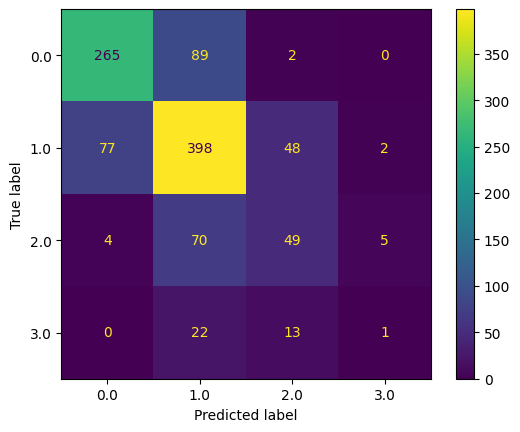

In [241]:
for score in scoring:
  idbest = results.loc[results['scoring']==score, score].idxmax(axis=0)
  best_clf = clfs[idbest]
  disp = ConfusionMatrixDisplay.from_estimator(best_clf,X_test,y_test)